# CBIS-DDSM Data Preprocessing

This notebook loads, cleans, and prepares the CBIS-DDSM mammography dataset.
It performs the following steps:
1. Loads raw CSVs and fixes image paths.
2. Checks for missing values and corrupt images.
3. Analyzes class distribution.
4. Saves cleaned CSVs.
5. Verifies PyTorch DataLoaders and Transforms.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, auc, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, matthews_corrcoef
)
import timm
from tqdm.notebook import tqdm  # Use notebook version of tqdm
import warnings

warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Thu Dec  4 21:09:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 🔗 Setup Google Drive Access

**Important:** This notebook uses data stored in Google Drive.

**Shared Folder Link:** [CBIS-DDSM Data](https://drive.google.com/drive/folders/1KmZLUAbrlm6gEbMxyqI2vqneE9bjdh_D?usp=sharing)

### 📋 Setup Steps:
1. **Add folder to your Drive:**
   - Click the shared folder link above
   - Click "Add shortcut to Drive" (⭐ icon) or right-click → "Add to My Drive"
   - Note where you place it (default: MyDrive root)

2. **Run the next cell** to mount Google Drive and configure paths
   - Allow browser popups for authentication
   - Grant necessary permissions

3. **Verify the path:**
   - The cell will check if directories exist
   - If path is different, update `BASE_DIR` in the next cell

### 📁 Expected Folder Structure:
```
CBIS-DDSM/
├── csv/              # CSV metadata files
├── jpeg/             # JPEG images
├── png/              # PNG images
├── split_train.csv
├── split_test.csv
└── split_val.csv
```

### ⚠️ Troubleshooting "mount failed" Error:

**If you see `ValueError: mount failed`:**

1. **Restart Runtime First:**
   - `Runtime` → `Restart runtime`
   - Then run the mount cell again

2. **Check Browser Popups:**
   - Enable popups for colab.research.google.com
   - Clear browser cache if needed

3. **Force Remount (if needed):**
   ```python
   drive.mount('/content/drive', force_remount=True)
   ```

4. **Already Mounted?**
   - If you see "already mounted" message, you're good to proceed!

5. **Authentication Timeout:**
   - Try authenticating faster when the popup appears
   - Use a stable internet connection

In [ ]:
# --- MOUNT GOOGLE DRIVE ---
import os
from google.colab import drive

# Check if already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    try:
        drive.mount('/content/drive', force_remount=False)
        print("✓ Google Drive mounted successfully!")
    except Exception as e:
        print(f"❌ Mount failed: {e}")
        print("\n🔧 Troubleshooting Steps:")
        print("1. Runtime → Restart runtime (to clear any corrupted mount state)")
        print("2. Allow popups in your browser for authentication")
        print("3. Try running this cell again")
        print("4. If still failing, try: drive.mount('/content/drive', force_remount=True)")
        raise
else:
    print("✓ Google Drive is already mounted at /content/drive")

# --- CONFIGURATION ---
# Google Drive shared folder link: https://drive.google.com/drive/folders/1KmZLUAbrlm6gEbMxyqI2vqneE9bjdh_D?usp=sharing
# Base directory pointing to the mounted Google Drive folder
BASE_DIR = "/content/drive/MyDrive/CBIS-DDSM"  # Adjust this path to match where you placed the shared folder
CSV_DIR = os.path.join(BASE_DIR, "csv")
JPEG_DIR = os.path.join(BASE_DIR, "jpeg")
PNG_DIR = os.path.join(BASE_DIR, "png")

OUTPUT_DIR = os.path.join(BASE_DIR, "preprocessed_data")
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 2

print(f"\n📊 Configuration:")
print(f"Device: {DEVICE}")
print(f"Base Directory: {BASE_DIR}")
print(f"CSV Directory: {CSV_DIR}")
print(f"JPEG Directory: {JPEG_DIR}")
print(f"PNG Directory: {PNG_DIR}")

# Verify directories exist
print(f"\n🔍 Verifying paths...")
if os.path.exists(BASE_DIR):
    print(f"✓ Base directory found")
    if os.path.exists(CSV_DIR):
        print(f"✓ CSV directory found")
    else:
        print(f"❌ CSV directory NOT found at {CSV_DIR}")
    if os.path.exists(JPEG_DIR):
        print(f"✓ JPEG directory found")
    else:
        print(f"❌ JPEG directory NOT found at {JPEG_DIR}")
    if os.path.exists(PNG_DIR):
        print(f"✓ PNG directory found")
    else:
        print(f"❌ PNG directory NOT found at {PNG_DIR}")
else:
    print(f"❌ Base directory NOT found at {BASE_DIR}")
    print(f"💡 Make sure you've added the shared folder to your Google Drive")
    print(f"   and the path matches your folder location.")

ValueError: mount failed

In [ ]:
# Optional: List your MyDrive contents to find the folder
# Uncomment and run if you need to verify the folder location
# !ls -la "/content/drive/MyDrive/" | head -20

In [ ]:
class DataPreprocessor:
    """Handles all data preprocessing operations for CBIS-DDSM dataset"""

    def __init__(self, base_dir, output_dir):
        self.base_dir = base_dir
        self.output_dir = output_dir
        self.train_df = None
        self.val_df = None
        self.test_df = None

    def load_data(self):
        """Load train, validation, and test CSV files"""
        print("\nLoading data...")

        train_path = os.path.join(self.base_dir, "split_train.csv")
        val_path = os.path.join(self.base_dir, "split_val.csv")
        test_path = os.path.join(self.base_dir, "split_test.csv")

        self.train_df = pd.read_csv(train_path)
        self.val_df = pd.read_csv(val_path)
        self.test_df = pd.read_csv(test_path)

        # Fix paths to match current location
        print("Updating image paths...")
        self._fix_image_paths(self.train_df)
        self._fix_image_paths(self.val_df)
        self._fix_image_paths(self.test_df)

        print(f"Train: {len(self.train_df)} | Val: {len(self.val_df)} | Test: {len(self.test_df)}")

        return self.train_df, self.val_df, self.test_df

    def _fix_image_paths(self, df):
        """Update image paths to match current directory structure"""
        def update_path(row):
            old_path = row['jpg_path']
            if pd.isna(old_path): return old_path

            # Get filename from old path
            filename = os.path.basename(old_path)

            # Get SeriesInstanceUID if available to construct path
            uid = row.get('SeriesInstanceUID', '')
            if not uid and 'jpeg' in str(old_path):
                # Try to extract UID from path if not in column
                # Path structure: .../jpeg/UID/filename
                parts = str(old_path).replace('\\', '/').split('/')
                try:
                    idx = parts.index('jpeg')
                    uid = parts[idx+1]
                except (ValueError, IndexError):
                    pass

            if uid:
                # Construct new path: BASE/jpeg/UID/filename
                new_path = os.path.join(self.base_dir, "jpeg", str(uid), filename)
                return new_path
            return old_path

        if 'jpg_path' in df.columns:
            df['jpg_path'] = df.apply(update_path, axis=1)

    def check_missing_values(self, df, split_name):
        """Check for missing values in dataset"""
        missing = df.isnull().sum()
        if missing.sum() == 0:
            print(f"{split_name}: No missing values")
        else:
            print(f"{split_name} missing values:\n{missing[missing > 0]}")
        return missing

    def verify_image_paths(self, df, split_name):
        """Verify that all image paths exist"""
        missing_images = []
        for idx, row in df.iterrows():
            img_path = row['jpg_path']
            if not os.path.exists(img_path):
                missing_images.append(img_path)

        if len(missing_images) == 0:
            print(f"{split_name}: All {len(df)} images found")
        else:
            print(f"{split_name}: WARNING - {len(missing_images)} images not found")

        return missing_images

    def check_image_quality(self, df, split_name, sample_size=100):
        """Check a sample of images for quality issues"""
        print(f"{split_name}: Checking image quality (sample={sample_size})...")

        sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
        corrupt_images = []

        for idx, row in sample_df.iterrows():
            img_path = row['jpg_path']
            try:
                img = Image.open(img_path)
                img.verify()  # Verify image integrity
                img = Image.open(img_path)  # Reopen after verify
                img_array = np.array(img)

                # Check if image is not empty
                if img_array.size == 0:
                    corrupt_images.append(img_path)

            except Exception as e:
                corrupt_images.append(img_path)

        if len(corrupt_images) == 0:
            print(f"{split_name}: Images OK")
        else:
            print(f"{split_name}: WARNING - {len(corrupt_images)} corrupt images")

        return corrupt_images

    def analyze_class_distribution(self):
        """Analyze and display class distribution"""
        print("\nClass Distribution:")

        splits = [('Train', self.train_df), ('Validation', self.val_df), ('Test', self.test_df)]

        for split_name, df in splits:
            class_counts = df['label'].value_counts()
            total = len(df)

            print(f"{split_name}: Benign={class_counts.get(0, 0)} ({class_counts.get(0, 0)/total*100:.1f}%), Malignant={class_counts.get(1, 0)} ({class_counts.get(1, 0)/total*100:.1f}%)")

    def remove_duplicates(self, df, split_name):
        """Remove duplicate entries based on image path"""
        original_len = len(df)
        df_cleaned = df.drop_duplicates(subset=['jpg_path'], keep='first')
        removed = original_len - len(df_cleaned)

        if removed > 0:
            print(f"{split_name}: Removed {removed} duplicates")

        return df_cleaned

    def clean_data(self):
        """Perform comprehensive data cleaning"""
        print("\nStarting data cleaning...")

        # Check missing values
        for df, name in [(self.train_df, 'Train'), (self.val_df, 'Validation'), (self.test_df, 'Test')]:
            self.check_missing_values(df, name)

        # Verify image paths
        for df, name in [(self.train_df, 'Train'), (self.val_df, 'Validation'), (self.test_df, 'Test')]:
            self.verify_image_paths(df, name)

        # Check image quality
        for df, name in [(self.train_df, 'Train'), (self.val_df, 'Validation'), (self.test_df, 'Test')]:
            self.check_image_quality(df, name)

        # Remove duplicates
        self.train_df = self.remove_duplicates(self.train_df, 'Train')
        self.val_df = self.remove_duplicates(self.val_df, 'Validation')
        self.test_df = self.remove_duplicates(self.test_df, 'Test')

        # Analyze class distribution
        self.analyze_class_distribution()

        print("\nData cleaning complete.")

    def save_cleaned_data(self):
        """Save cleaned dataframes to CSV"""
        train_path = os.path.join(self.output_dir, "train_cleaned.csv")
        val_path = os.path.join(self.output_dir, "val_cleaned.csv")
        test_path = os.path.join(self.output_dir, "test_cleaned.csv")

        self.train_df.to_csv(train_path, index=False)
        self.val_df.to_csv(val_path, index=False)
        self.test_df.to_csv(test_path, index=False)

        print(f"\nSaved cleaned data to {self.output_dir}")

    def create_summary_report(self):
        """Create a summary report of preprocessing"""
        report = {
            'Dataset': 'CBIS-DDSM Breast Cancer Mammography',
            'Total_Samples': len(self.train_df) + len(self.val_df) + len(self.test_df),
            'Train_Samples': len(self.train_df),
            'Val_Samples': len(self.val_df),
            'Test_Samples': len(self.test_df),
            'Train_Class0': int((self.train_df['label'] == 0).sum()),
            'Train_Class1': int((self.train_df['label'] == 1).sum()),
            'Val_Class0': int((self.val_df['label'] == 0).sum()),
            'Val_Class1': int((self.val_df['label'] == 1).sum()),
            'Test_Class0': int((self.test_df['label'] == 0).sum()),
            'Test_Class1': int((self.test_df['label'] == 1).sum()),
        }

        report_path = os.path.join(self.output_dir, "preprocessing_summary.txt")
        with open(report_path, 'w') as f:
            f.write("CBIS-DDSM Preprocessing Summary\n\n")
            for key, value in report.items():
                f.write(f"{key.replace('_', ' ')}: {value}\n")

        print(f"Summary saved: {report_path}")
        return report


In [ ]:
class CBISDDSMDataset(Dataset):
    """Custom PyTorch Dataset for CBIS-DDSM images"""

    def __init__(self, csv_path, transform=None, image_size=224):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.image_size = image_size
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = row['jpg_path']
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get label
        label = torch.tensor(row['label'], dtype=torch.long)

        return image, label


In [ ]:
def get_data_transforms(image_size=224):
    # Training with data augmentation
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Validation and test (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


def create_data_loaders(output_dir, batch_size=32, image_size=224, num_workers=4):
    print("\nCreating data loaders...")

    train_transform, val_transform = get_data_transforms(image_size)

    train_dataset = CBISDDSMDataset(
        csv_path=os.path.join(output_dir, "train_cleaned.csv"),
        transform=train_transform,
        image_size=image_size
    )

    val_dataset = CBISDDSMDataset(
        csv_path=os.path.join(output_dir, "val_cleaned.csv"),
        transform=val_transform,
        image_size=image_size
    )

    test_dataset = CBISDDSMDataset(
        csv_path=os.path.join(output_dir, "test_cleaned.csv"),
        transform=val_transform,
        image_size=image_size
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Train: {len(train_loader)} batches | Val: {len(val_loader)} batches | Test: {len(test_loader)} batches")

    return train_loader, val_loader, test_loader

In [ ]:
preprocessor = DataPreprocessor(BASE, OUTPUT_DIR)

In [ ]:
preprocessor.load_data()


Loading data...
Updating image paths...
Train: 77 | Val: 15 | Test: 18


(                                    SeriesInstanceUID  \
 0   1.3.6.1.4.1.9590.100.1.2.101687785712357341314...   
 1   1.3.6.1.4.1.9590.100.1.2.103528897137404609425...   
 2   1.3.6.1.4.1.9590.100.1.2.116862306129239814098...   
 3   1.3.6.1.4.1.9590.100.1.2.119209042313843707415...   
 4   1.3.6.1.4.1.9590.100.1.2.124691472311866882937...   
 ..                                                ...   
 72  1.3.6.1.4.1.9590.100.1.2.683211001136656542077...   
 73  1.3.6.1.4.1.9590.100.1.2.730531623124381310207...   
 74  1.3.6.1.4.1.9590.100.1.2.734848824118740414325...   
 75  1.3.6.1.4.1.9590.100.1.2.849693330115813124246...   
 76  1.3.6.1.4.1.9590.100.1.2.994148157120552488288...   
 
                                              jpg_path SeriesDescription  \
 0   C:\Users\uw_admin\Documents\ML\Project\CBIS-DD...    cropped images   
 1   C:\Users\uw_admin\Documents\ML\Project\CBIS-DD...    cropped images   
 2   C:\Users\uw_admin\Documents\ML\Project\CBIS-DD...    cropped images  

In [ ]:
preprocessor.clean_data()


Starting data cleaning...
Train: No missing values
Validation: No missing values
Test: No missing values
Train: All 77 images found
Validation: All 15 images found
Test: All 18 images found
Train: Checking image quality (sample=100)...
Train: Images OK
Validation: Checking image quality (sample=100)...
Validation: Images OK
Test: Checking image quality (sample=100)...
Test: Images OK

Class Distribution:
Train: Benign=58 (75.3%), Malignant=19 (24.7%)
Validation: Benign=12 (80.0%), Malignant=3 (20.0%)
Test: Benign=13 (72.2%), Malignant=5 (27.8%)

Data cleaning complete.


In [ ]:
preprocessor.save_cleaned_data()


Saved cleaned data to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\preprocessed_data


In [ ]:
preprocessor.create_summary_report()

Summary saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\preprocessed_data\preprocessing_summary.txt


{'Dataset': 'CBIS-DDSM Breast Cancer Mammography',
 'Total_Samples': 110,
 'Train_Samples': 77,
 'Val_Samples': 15,
 'Test_Samples': 18,
 'Train_Class0': 58,
 'Train_Class1': 19,
 'Val_Class0': 12,
 'Val_Class1': 3,
 'Test_Class0': 13,
 'Test_Class1': 5}

In [ ]:

print("\nTesting data loaders...")
train_loader, val_loader, test_loader = create_data_loaders(
    OUTPUT_DIR,
    batch_size=32,
    image_size=224,
    num_workers=0  # Use 0 for Windows compatibility
)

images, labels = next(iter(train_loader))
print(f"Batch: {images.shape}, dtype: {images.dtype}")
print(f"Labels: {labels.shape}, dtype: {labels.dtype}")

print("\nPreprocessing complete!")
print(f"Output: {OUTPUT_DIR}")


Testing data loaders...

Creating data loaders...
Train: 3 batches | Val: 1 batches | Test: 1 batches
Batch: torch.Size([32, 3, 224, 224]), dtype: torch.float32
Labels: torch.Size([32]), dtype: torch.int64

Preprocessing complete!
Output: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\preprocessed_data


## Model Creation

In [ ]:
class MetricsCalculator:
    """Calculate all evaluation metrics"""

    @staticmethod
    def calculate_all_metrics(y_true, y_pred, y_pred_proba):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1': f1_score(y_true, y_pred, zero_division=0),
            'ROC_AUC': roc_auc_score(y_true, y_pred_proba),
            'PR_AUC': average_precision_score(y_true, y_pred_proba),
            'Sensitivity_TPR': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Specificity_TNR': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'MCC': matthews_corrcoef(y_true, y_pred)
        }
        return metrics

    @staticmethod
    def print_metrics(metrics, model, phase='Test'):
        print(f"\n{phase} Metrics - {model}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name.replace('_', ' ')}: {value:.4f}")


In [ ]:
class Visualizer:
    """Create and save visualizations"""

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, output_path):
        """Plot and save confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Benign', 'Malignant'],
                   yticklabels=['Benign', 'Malignant'],
                   cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix - ConvNeXt', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Confusion matrix saved: {output_path}")

    @staticmethod
    def plot_roc_curve(y_true, y_pred_proba, output_path):
        """Plot and save ROC curve"""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve - ConvNeXt', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"ROC curve saved: {output_path}")

    @staticmethod
    def plot_pr_curve(y_true, y_pred_proba, output_path):
        """Plot and save Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2,
                label=f'PR curve (AUC = {pr_auc:.4f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve - ConvNeXt', fontsize=14, fontweight='bold')
        plt.legend(loc='lower left', fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"PR curve saved: {output_path}")

    @staticmethod
    def plot_training_history(train_losses, val_losses, train_accs, val_accs, output_path):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Loss plot
        ax1.plot(train_losses, label='Train Loss', marker='o')
        ax1.plot(val_losses, label='Validation Loss', marker='s')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Accuracy plot
        ax2.plot(train_accs, label='Train Accuracy', marker='o')
        ax2.plot(val_accs, label='Validation Accuracy', marker='s')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Training history saved: {output_path}")

In [ ]:
class Trainer:
    """Handle model training"""

    def __init__(self, model, device, train_loader, val_loader, save_dir, model_name):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.save_dir = save_dir
        self.model_name = model_name

        # Calculate class weights to handle imbalance
        class_weights = self._calculate_class_weights()
        print(f"\nClass weights: {class_weights}")

        # Hyperparameters
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        self.optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )

        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.best_val_loss = float('inf')

    def _calculate_class_weights(self):
        """Calculate class weights based on training data distribution"""
        print("\nCalculating class weights...")
        class_counts = [0, 0]

        for _, labels in self.train_loader:
            for label in labels:
                class_counts[label.item()] += 1

        total = sum(class_counts)
        # Inverse frequency weighting
        weights = [total / (len(class_counts) * count) for count in class_counts]
        weights_tensor = torch.FloatTensor(weights).to(self.device)

        print(f"Class distribution: Class 0 (Benign): {class_counts[0]}, Class 1 (Malignant): {class_counts[1]}")
        print(f"Computed weights: Class 0: {weights[0]:.4f}, Class 1: {weights[1]:.4f}")

        return weights_tensor

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc='Training')
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        return epoch_loss, epoch_acc

    def validate(self):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc='Validation'):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        return epoch_loss, epoch_acc

    def train(self, num_epochs):
        """Complete training loop"""
        print(f"\nStarting {self.model_name} training") # Use dynamic name
        print(f"Device: {self.device} | Epochs: {num_epochs} | LR: {LEARNING_RATE}")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 60)

            # Train
            train_loss, train_acc = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # Validate
            val_loss, val_acc = self.validate()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                best_model_path = os.path.join(self.save_dir, f'{self.model_name}_best.pth')
                torch.save(self.model.state_dict(), best_model_path)
                print(f"Best model saved to {best_model_path}")

        print("\nTraining complete")

In [ ]:
class Evaluator:
    """Handle model evaluation"""

    def __init__(self, model, device, test_loader):
        self.model = model
        self.device = device
        self.test_loader = test_loader

    def evaluate(self):
        """Evaluate model on test set"""
        print("\nEvaluating on test set...")

        self.model.eval()
        all_labels = []
        all_preds = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc='Testing'):
                images = images.to(self.device)
                outputs = self.model(images)

                # Get predictions and probabilities
                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class

        # Convert to numpy arrays
        y_true = np.array(all_labels)
        y_pred = np.array(all_preds)
        y_pred_proba = np.array(all_probs)

        return y_true, y_pred, y_pred_proba


def save_metrics_to_csv(metrics, output_path):
    df = pd.DataFrame([metrics])
    df.to_csv(output_path, index=False)
    print(f"Metrics saved: {output_path}")

### ConvNext

In [ ]:
class ConvNeXtClassifier(nn.Module):
    """ConvNeXt model for binary classification"""

    def __init__(self, model_name='convnext_tiny', num_classes=2, pretrained=True):
        super(ConvNeXtClassifier, self).__init__()

        # Load pretrained ConvNeXt from timm
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

### Custom CNN (Baseline)

In [ ]:
class CustomCNNClassifier(nn.Module):
    """Small Custom CNN from original notebook"""
    def __init__(self, num_classes=2):
        super(CustomCNNClassifier, self).__init__()
        # Input channels = 3 (RGB)
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.flatten(1)
        return self.fc(x)

### DenseNet - 121

In [ ]:
class DenseNet121Classifier(nn.Module):
    """DenseNet121 model for binary classification"""

    def __init__(self, num_classes=2, pretrained=True):
        super(DenseNet121Classifier, self).__init__()

        # Load pretrained DenseNet121
        self.model = models.densenet121(pretrained=pretrained)

        # Get number of input features for classifier
        num_features = self.model.classifier.in_features

        # Replace classifier with custom one
        self.model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

### EfficientNet

In [ ]:
class EfficientNetClassifier(nn.Module):
    """EfficientNet-B0 model for binary classification"""

    def __init__(self, num_classes=2, pretrained=True):
        super(EfficientNetClassifier, self).__init__()

        # Load EfficientNet-B0
        if pretrained:
            # Load model without pretrained weights first, then load manually
            self.model = models.efficientnet_b0(weights=None)
            # Load pretrained weights with hash check disabled
            import torch.hub as hub
            state_dict = hub.load_state_dict_from_url(
                'https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth',
                progress=True,
                check_hash=False  # Disable hash checking to avoid mismatch
            )
            self.model.load_state_dict(state_dict)
        else:
            self.model = models.efficientnet_b0(weights=None)

        # Modify final classifier layer for binary classification
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### ResNet18

In [ ]:
class ResNet18Classifier(nn.Module):
    """ResNet18 model for binary classification"""

    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet18Classifier, self).__init__()

        # Load pretrained ResNet18
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        self.model = models.resnet18(weights=weights)

        # Modify final fully connected layer for binary classification
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### ResNet50

In [ ]:
class ResNet50Classifier(nn.Module):
    """ResNet50 model for binary classification"""

    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet50Classifier, self).__init__()

        # Load pretrained ResNet50
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.model = models.resnet50(weights=weights)

        # Modify final fully connected layer for binary classification
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### SWIN Transformer

In [ ]:
class SwinTransformerClassifier(nn.Module):
    """Swin Transformer model for binary classification"""

    def __init__(self, model_name='swin_tiny_patch4_window7_224', num_classes=2, pretrained=True):
        super(SwinTransformerClassifier, self).__init__()

        # Load pretrained Swin Transformer with correct num_classes
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


### SWIN Transformer (Multi-View)

In [ ]:
class MultiViewSwinTransformer(nn.Module):
    """Multi-view Swin Transformer for binary classification"""

    def __init__(self, model_name='swin_tiny_patch4_window7_224', num_classes=2, pretrained=True):
        super(MultiViewSwinTransformer, self).__init__()

        # For simplicity, use the standard Swin model with proper num_classes
        # This can be extended to true multi-view when needed
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        """
        return self.model(x)

    def forward_multiview(self, views):
        """
        Forward pass for true multi-view input
        Args:
            views: List of tensors, each of shape (batch_size, channels, height, width)
        """
        batch_size = views[0].size(0)

        # Extract features from each view
        view_features = []
        for view in views:
            features = self.backbone(view)
            view_features.append(features.unsqueeze(1))

        # Stack features: (batch_size, num_views, feature_dim)
        stacked_features = torch.cat(view_features, dim=1)

        # Aggregate across views using max pooling
        # Reshape for pooling: (batch_size, feature_dim, num_views)
        stacked_features = stacked_features.transpose(1, 2)
        aggregated = self.aggregation(stacked_features).squeeze(-1)

        # Classify
        output = self.classifier(aggregated)

        return output

### U-Net

In [ ]:
class DoubleConv(nn.Module):
    """Double convolution block for U-Net"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Concatenate skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNetClassifier(nn.Module):
    """U-Net architecture adapted for binary classification

    Traditional U-Net is for segmentation, but we adapt it for classification by:
    1. Using the encoder path to extract hierarchical features
    2. Using the decoder path to refine features
    3. Adding global pooling and classification head at the end
    """

    def __init__(self, num_classes=2, in_channels=3):
        super(UNetClassifier, self).__init__()

        # Encoder (downsampling path)
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Decoder (upsampling path)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Classification
        x = self.global_pool(x)
        x = self.classifier(x)

        return x

## Train and Test

In [ ]:
def get_model_instance(model_name, num_classes, device):
    """Factory function to initialize the correct model architecture"""
    all_models = [
        'custom_cnn',
        'resnet18',
        'resnet50',
        'densenet121',
        'efficientnet',
        'convnext',
        'swin',
        'swin_multiview',
        'unet'
        ]

    if model_name == 'convnext':
        return ConvNeXtClassifier(model_name='convnext_tiny', num_classes=num_classes).to(device)
    elif model_name == 'custom_cnn':
        return CustomCNNClassifier(num_classes=num_classes).to(device)
    elif model_name == 'densenet121':
        return DenseNet121Classifier(num_classes=num_classes).to(device)
    elif model_name == 'efficientnet':
        return EfficientNetClassifier(num_classes=num_classes, pretrained=True).to(device)
    elif model_name == 'resnet18':
        return ResNet18Classifier(num_classes=num_classes,pretrained=True).to(device)
    elif model_name == 'resnet50':
        return ResNet50Classifier(num_classes=num_classes,pretrained=True).to(device)
    elif model_name == 'swin':
        return SwinTransformerClassifier(
            model_name="swin_tiny_patch4_window7_224",
            num_classes=num_classes,
            pretrained=True
            ).to(device)
    elif model_name == 'swin_multiview':
        return MultiViewSwinTransformer(
            model_name="swin_tiny_patch4_window7_224",
            num_classes=num_classes,
            pretrained=True
            ).to(device)
    elif model_name == 'unet':
        return UNetClassifier(num_classes=num_classes, in_channels=3).to(device)
    else:
        raise ValueError(f"Model class for {model_name} not found.")

In [ ]:
def run_model_pipeline(model_name, base_model_dir, base_results_dir):
    print(f"\n{'='*20}\nRunning Pipeline for: {model_name}\n{'='*20}")

    # 1. Create Dynamic Paths for this specific model
    # e.g., .../models/convnext
    current_model_dir = os.path.join(base_model_dir, model_name)
    # e.g., .../results/convnext
    current_results_dir = os.path.join(base_results_dir, model_name)

    os.makedirs(current_model_dir, exist_ok=True)
    os.makedirs(current_results_dir, exist_ok=True)

    # 2. Data Loaders (Assuming create_data_loaders is defined globally)
    # You might want to move this outside the loop if data is same for all models to save time
    train_loader, val_loader, test_loader = create_data_loaders(
        OUTPUT_DIR, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, num_workers=0
    )

    # 3. Initialize Model
    model = get_model_instance(model_name, NUM_CLASSES, DEVICE)

    # 4. Train (Pass the dynamic directory here)
    trainer = Trainer(
        model=model,
        device=DEVICE,
        train_loader=train_loader,
        val_loader=val_loader,
        save_dir=current_model_dir,    # <--- DYNAMIC PATH
        model_name=model_name          # <--- DYNAMIC NAME
    )
    trainer.train(NUM_EPOCHS)

    # 5. Visualizations (Use current_results_dir)
    Visualizer.plot_training_history(
        trainer.train_losses, trainer.val_losses,
        trainer.train_accs, trainer.val_accs,
        os.path.join(current_results_dir, 'training_history.png')
    )

    # 6. Evaluation
    best_model_path = os.path.join(current_model_dir, f'{model_name}_best.pth')
    model.load_state_dict(torch.load(best_model_path))

    evaluator = Evaluator(model, DEVICE, test_loader)
    y_true, y_pred, y_pred_proba = evaluator.evaluate()

    # Save Results
    np.savez(os.path.join(current_results_dir, 'predictions.npz'),
             y_true=y_true, y_pred=y_pred, y_pred_proba=y_pred_proba)

    metrics_calc = MetricsCalculator()
    metrics = metrics_calc.calculate_all_metrics(y_true, y_pred, y_pred_proba)
    save_metrics_to_csv(metrics, os.path.join(current_results_dir, 'test_metrics.csv'))

    visualizer = Visualizer()
    visualizer.plot_confusion_matrix(y_true, y_pred, os.path.join(current_results_dir, 'confusion_matrix.png'))
    visualizer.plot_roc_curve(y_true, y_pred_proba, os.path.join(current_results_dir, 'roc_curve.png'))
    visualizer.plot_pr_curve(y_true, y_pred_proba, os.path.join(current_results_dir, 'pr_curve.png'))

In [ ]:
# Base Directories
OUTPUT_MODEL_DIR = r"C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison"
BASE_MODEL_DIR = r"C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models"
BASE_RESULTS_DIR = r"C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results"

all_models = [
    'custom_cnn',
    'resnet18',
    'resnet50',
    'densenet121',
    'efficientnet',
    'convnext',
    'swin',
    'swin_multiview',
    'unet'
]

for model_name in all_models:
    folder_path = os.path.join(OUTPUT_MODEL_DIR, model_name)

    os.makedirs(folder_path, exist_ok=True)

    print(f"Created/Verified directory: {folder_path}")


# Run the loop
for model_name in all_models:
    try:
        run_model_pipeline(model_name, BASE_MODEL_DIR, BASE_RESULTS_DIR)
    except Exception as e:
        print(f"Error running pipeline for {model_name}: {e}")
        continue # Continue to next model if one fails

Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\custom_cnn
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\resnet18
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\resnet50
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\densenet121
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\efficientnet
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\convnext
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\swin
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\swin_multiview
Created/Verified directory: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDS

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7059 | Train Acc: 0.4675
Val Loss: 0.6887 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6923 | Train Acc: 0.5974
Val Loss: 0.6863 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6377 | Train Acc: 0.6883
Val Loss: 0.6875 | Val Acc: 0.8000

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6737 | Train Acc: 0.6494
Val Loss: 0.6895 | Val Acc: 0.6667

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6842 | Train Acc: 0.5974
Val Loss: 0.6885 | Val Acc: 0.6000

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6462 | Train Acc: 0.6753
Val Loss: 0.6916 | Val Acc: 0.6000

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6585 | Train Acc: 0.6104
Val Loss: 0.7268 | Val Acc: 0.5333

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6425 | Train Acc: 0.6104
Val Loss: 0.7056 | Val Acc: 0.6667

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6720 | Train Acc: 0.6364
Val Loss: 0.7100 | Val Acc: 0.6000

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6718 | Train Acc: 0.6494
Val Loss: 0.6905 | Val Acc: 0.6667

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6606 | Train Acc: 0.6104
Val Loss: 0.6641 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6131 | Train Acc: 0.7013
Val Loss: 0.6501 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6844 | Train Acc: 0.6623
Val Loss: 0.6373 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6551 | Train Acc: 0.6623
Val Loss: 0.6326 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6274 | Train Acc: 0.7013
Val Loss: 0.6272 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6598 | Train Acc: 0.6364
Val Loss: 0.6189 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6573 | Train Acc: 0.5714
Val Loss: 0.6100 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6992 | Train Acc: 0.4545
Val Loss: 0.6074 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\custom_cnn\custom_cnn_best.pth

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6685 | Train Acc: 0.6364
Val Loss: 0.6099 | Val Acc: 0.7333

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6300 | Train Acc: 0.7013
Val Loss: 0.6375 | Val Acc: 0.6000

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6608 | Train Acc: 0.6753
Val Loss: 0.6618 | Val Acc: 0.6000

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6608 | Train Acc: 0.6623
Val Loss: 0.6581 | Val Acc: 0.6000

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6386 | Train Acc: 0.7143
Val Loss: 0.6360 | Val Acc: 0.6000

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6349 | Train Acc: 0.7013
Val Loss: 0.6331 | Val Acc: 0.6667

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6398 | Train Acc: 0.7143
Val Loss: 0.6301 | Val Acc: 0.7333

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6745 | Train Acc: 0.6104
Val Loss: 0.6255 | Val Acc: 0.6667

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6626 | Train Acc: 0.6364
Val Loss: 0.6210 | Val Acc: 0.6000

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6268 | Train Acc: 0.6753
Val Loss: 0.6210 | Val Acc: 0.6000

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6466 | Train Acc: 0.6364
Val Loss: 0.6232 | Val Acc: 0.6000

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6298 | Train Acc: 0.6753
Val Loss: 0.6264 | Val Acc: 0.6000

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\custom_cnn\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\custom_cnn\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\custom_cnn\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\custom_cnn\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\custom_cnn\pr_curve.png

Running Pipeline for: resnet18

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting resnet18 training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7298 | Train Acc: 0.3506
Val Loss: 0.7995 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5988 | Train Acc: 0.5455
Val Loss: 0.7498 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6681 | Train Acc: 0.6623
Val Loss: 0.6742 | Val Acc: 0.4667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4885 | Train Acc: 0.7143
Val Loss: 0.6493 | Val Acc: 0.5333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5154 | Train Acc: 0.6883
Val Loss: 0.5687 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4345 | Train Acc: 0.8052
Val Loss: 0.5067 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4466 | Train Acc: 0.7922
Val Loss: 0.4819 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3698 | Train Acc: 0.8182
Val Loss: 0.5472 | Val Acc: 0.7333

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3940 | Train Acc: 0.7662
Val Loss: 0.6741 | Val Acc: 0.8000

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3629 | Train Acc: 0.8052
Val Loss: 0.6942 | Val Acc: 0.8667

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3661 | Train Acc: 0.8052
Val Loss: 0.6402 | Val Acc: 0.8667

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3334 | Train Acc: 0.8312
Val Loss: 0.6724 | Val Acc: 0.8000

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2767 | Train Acc: 0.8961
Val Loss: 0.6418 | Val Acc: 0.8667

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2565 | Train Acc: 0.8701
Val Loss: 0.6017 | Val Acc: 0.8667

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3543 | Train Acc: 0.8701
Val Loss: 0.5713 | Val Acc: 0.8000

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2879 | Train Acc: 0.8571
Val Loss: 0.6048 | Val Acc: 0.8000

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3129 | Train Acc: 0.8571
Val Loss: 0.5882 | Val Acc: 0.8667

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3976 | Train Acc: 0.8442
Val Loss: 0.5905 | Val Acc: 0.9333

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2553 | Train Acc: 0.9221
Val Loss: 0.5542 | Val Acc: 0.9333

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2201 | Train Acc: 0.9481
Val Loss: 0.5253 | Val Acc: 0.8000

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2180 | Train Acc: 0.9091
Val Loss: 0.5016 | Val Acc: 0.8000

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2085 | Train Acc: 0.9221
Val Loss: 0.4867 | Val Acc: 0.8000

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2188 | Train Acc: 0.8961
Val Loss: 0.4430 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1828 | Train Acc: 0.9351
Val Loss: 0.4537 | Val Acc: 0.8000

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1651 | Train Acc: 0.9481
Val Loss: 0.4594 | Val Acc: 0.8000

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1599 | Train Acc: 0.9481
Val Loss: 0.4951 | Val Acc: 0.8000

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1625 | Train Acc: 0.9610
Val Loss: 0.4705 | Val Acc: 0.8000

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2279 | Train Acc: 0.9481
Val Loss: 0.4197 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet18\resnet18_best.pth

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1151 | Train Acc: 0.9481
Val Loss: 0.4329 | Val Acc: 0.9333

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3248 | Train Acc: 0.8701
Val Loss: 0.4323 | Val Acc: 0.9333

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet18\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet18\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet18\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet18\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet18\pr_curve.png

Running Pipeline for: resnet50

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting resnet50 training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6830 | Train Acc: 0.4416
Val Loss: 0.6844 | Val Acc: 0.4667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6854 | Train Acc: 0.5325
Val Loss: 0.6896 | Val Acc: 0.4667

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6717 | Train Acc: 0.7532
Val Loss: 0.6859 | Val Acc: 0.4667

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6486 | Train Acc: 0.7403
Val Loss: 0.6804 | Val Acc: 0.4667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6336 | Train Acc: 0.7273
Val Loss: 0.6326 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6434 | Train Acc: 0.7013
Val Loss: 0.6289 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5976 | Train Acc: 0.7792
Val Loss: 0.6776 | Val Acc: 0.6000

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5627 | Train Acc: 0.6753
Val Loss: 0.6616 | Val Acc: 0.8000

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5891 | Train Acc: 0.7013
Val Loss: 0.6304 | Val Acc: 0.7333

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5299 | Train Acc: 0.6883
Val Loss: 0.5636 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4887 | Train Acc: 0.8052
Val Loss: 0.5266 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4886 | Train Acc: 0.7532
Val Loss: 0.4830 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4505 | Train Acc: 0.8052
Val Loss: 0.4936 | Val Acc: 0.6667

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3831 | Train Acc: 0.8442
Val Loss: 0.4577 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4165 | Train Acc: 0.7922
Val Loss: 0.5133 | Val Acc: 0.9333

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4665 | Train Acc: 0.7792
Val Loss: 0.5562 | Val Acc: 0.9333

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4010 | Train Acc: 0.8312
Val Loss: 0.8245 | Val Acc: 0.8667

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3897 | Train Acc: 0.7792
Val Loss: 0.5497 | Val Acc: 0.8667

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3671 | Train Acc: 0.8442
Val Loss: 0.5110 | Val Acc: 0.8667

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3459 | Train Acc: 0.8312
Val Loss: 0.4575 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3009 | Train Acc: 0.8961
Val Loss: 0.3774 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3324 | Train Acc: 0.8442
Val Loss: 0.3700 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3902 | Train Acc: 0.8052
Val Loss: 0.4502 | Val Acc: 0.7333

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2765 | Train Acc: 0.8701
Val Loss: 0.3505 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\resnet50\resnet50_best.pth

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3504 | Train Acc: 0.8312
Val Loss: 0.3862 | Val Acc: 0.8667

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2713 | Train Acc: 0.9221
Val Loss: 0.4033 | Val Acc: 0.8667

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3416 | Train Acc: 0.8831
Val Loss: 0.3736 | Val Acc: 0.8000

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2891 | Train Acc: 0.8701
Val Loss: 0.5133 | Val Acc: 0.6000

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2724 | Train Acc: 0.8961
Val Loss: 0.6582 | Val Acc: 0.6000

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1811 | Train Acc: 0.8961
Val Loss: 0.7487 | Val Acc: 0.6000

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet50\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet50\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet50\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet50\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\resnet50\pr_curve.png

Running Pipeline for: densenet121

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting densenet121 training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6899 | Train Acc: 0.6104
Val Loss: 0.5474 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6400 | Train Acc: 0.6104
Val Loss: 0.5993 | Val Acc: 0.8667

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5845 | Train Acc: 0.7273
Val Loss: 0.6574 | Val Acc: 0.7333

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5334 | Train Acc: 0.7273
Val Loss: 0.5331 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5384 | Train Acc: 0.7532
Val Loss: 0.4849 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4892 | Train Acc: 0.7662
Val Loss: 0.4173 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4588 | Train Acc: 0.8182
Val Loss: 0.3512 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4330 | Train Acc: 0.7922
Val Loss: 0.3319 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4083 | Train Acc: 0.8182
Val Loss: 0.2961 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4783 | Train Acc: 0.7662
Val Loss: 0.3357 | Val Acc: 0.8667

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3857 | Train Acc: 0.8442
Val Loss: 0.3157 | Val Acc: 0.9333

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3392 | Train Acc: 0.8571
Val Loss: 0.3596 | Val Acc: 0.9333

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4315 | Train Acc: 0.8052
Val Loss: 0.3561 | Val Acc: 0.9333

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3163 | Train Acc: 0.8701
Val Loss: 0.4312 | Val Acc: 0.8667

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3431 | Train Acc: 0.8701
Val Loss: 0.4582 | Val Acc: 0.7333

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3542 | Train Acc: 0.8312
Val Loss: 0.5147 | Val Acc: 0.7333

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3311 | Train Acc: 0.8312
Val Loss: 0.4837 | Val Acc: 0.7333

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1733 | Train Acc: 0.9481
Val Loss: 0.4063 | Val Acc: 0.7333

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2881 | Train Acc: 0.9091
Val Loss: 0.3627 | Val Acc: 0.8000

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2647 | Train Acc: 0.8961
Val Loss: 0.3185 | Val Acc: 0.8000

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2122 | Train Acc: 0.9481
Val Loss: 0.2773 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1708 | Train Acc: 0.9351
Val Loss: 0.2499 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2279 | Train Acc: 0.9221
Val Loss: 0.2050 | Val Acc: 0.9333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\densenet121\densenet121_best.pth

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2445 | Train Acc: 0.8831
Val Loss: 0.2244 | Val Acc: 0.9333

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2429 | Train Acc: 0.9351
Val Loss: 0.2342 | Val Acc: 0.9333

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2906 | Train Acc: 0.9091
Val Loss: 0.3161 | Val Acc: 0.8667

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3775 | Train Acc: 0.7922
Val Loss: 0.3123 | Val Acc: 0.8667

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2274 | Train Acc: 0.8961
Val Loss: 0.3106 | Val Acc: 0.8000

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1952 | Train Acc: 0.9221
Val Loss: 0.3179 | Val Acc: 0.8667

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1792 | Train Acc: 0.9351
Val Loss: 0.3123 | Val Acc: 0.8667

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\densenet121\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\densenet121\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\densenet121\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\densenet121\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\densenet121\pr_curve.png

Running Pipeline for: efficientnet

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting efficientnet training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6804 | Train Acc: 0.5325
Val Loss: 0.6573 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6606 | Train Acc: 0.5584
Val Loss: 0.6798 | Val Acc: 0.7333

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6395 | Train Acc: 0.6494
Val Loss: 0.6584 | Val Acc: 0.7333

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6038 | Train Acc: 0.7013
Val Loss: 0.6060 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5765 | Train Acc: 0.7532
Val Loss: 0.5893 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6019 | Train Acc: 0.6883
Val Loss: 0.5752 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5753 | Train Acc: 0.7532
Val Loss: 0.5683 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4974 | Train Acc: 0.7662
Val Loss: 0.5761 | Val Acc: 0.6000

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5747 | Train Acc: 0.7013
Val Loss: 0.5973 | Val Acc: 0.5333

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4760 | Train Acc: 0.8182
Val Loss: 0.6123 | Val Acc: 0.5333

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4971 | Train Acc: 0.7403
Val Loss: 0.6224 | Val Acc: 0.4667

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4445 | Train Acc: 0.8442
Val Loss: 0.6063 | Val Acc: 0.5333

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4790 | Train Acc: 0.7662
Val Loss: 0.5932 | Val Acc: 0.5333

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4559 | Train Acc: 0.8052
Val Loss: 0.5652 | Val Acc: 0.5333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5578 | Train Acc: 0.7403
Val Loss: 0.5588 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5344 | Train Acc: 0.6883
Val Loss: 0.5623 | Val Acc: 0.6000

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3979 | Train Acc: 0.8182
Val Loss: 0.5694 | Val Acc: 0.6000

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4251 | Train Acc: 0.8052
Val Loss: 0.5583 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4172 | Train Acc: 0.8571
Val Loss: 0.5341 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3629 | Train Acc: 0.8701
Val Loss: 0.5035 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4221 | Train Acc: 0.7792
Val Loss: 0.4942 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3479 | Train Acc: 0.8831
Val Loss: 0.4887 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3554 | Train Acc: 0.8052
Val Loss: 0.4843 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\efficientnet\efficientnet_best.pth

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3325 | Train Acc: 0.8571
Val Loss: 0.5008 | Val Acc: 0.6000

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3357 | Train Acc: 0.9091
Val Loss: 0.5043 | Val Acc: 0.6667

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3199 | Train Acc: 0.8701
Val Loss: 0.4937 | Val Acc: 0.6667

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3607 | Train Acc: 0.8571
Val Loss: 0.4901 | Val Acc: 0.6667

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3223 | Train Acc: 0.8442
Val Loss: 0.5328 | Val Acc: 0.6667

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3034 | Train Acc: 0.8701
Val Loss: 0.5303 | Val Acc: 0.6667

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3315 | Train Acc: 0.8571
Val Loss: 0.5251 | Val Acc: 0.6667

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\efficientnet\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\efficientnet\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\efficientnet\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\efficientnet\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\efficientnet\pr_curve.png

Running Pipeline for: convnext

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting convnext training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 1.8626 | Train Acc: 0.3766
Val Loss: 0.7081 | Val Acc: 0.2000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7295 | Train Acc: 0.6494
Val Loss: 0.6841 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7459 | Train Acc: 0.7662
Val Loss: 0.7161 | Val Acc: 0.2000

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7224 | Train Acc: 0.2468
Val Loss: 0.6955 | Val Acc: 0.2000

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6883 | Train Acc: 0.6753
Val Loss: 0.6828 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6851 | Train Acc: 0.7662
Val Loss: 0.6892 | Val Acc: 0.8000

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6814 | Train Acc: 0.3247
Val Loss: 0.6964 | Val Acc: 0.2000

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6817 | Train Acc: 0.6104
Val Loss: 0.6804 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6890 | Train Acc: 0.5325
Val Loss: 0.6777 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6815 | Train Acc: 0.7532
Val Loss: 0.6747 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6909 | Train Acc: 0.3766
Val Loss: 0.6688 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6917 | Train Acc: 0.7532
Val Loss: 0.6529 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7049 | Train Acc: 0.4416
Val Loss: 0.6675 | Val Acc: 0.2000

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7255 | Train Acc: 0.5974
Val Loss: 0.6945 | Val Acc: 0.8000

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6766 | Train Acc: 0.5844
Val Loss: 0.7198 | Val Acc: 0.2000

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7350 | Train Acc: 0.3377
Val Loss: 0.6818 | Val Acc: 0.8000

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6724 | Train Acc: 0.7662
Val Loss: 0.6868 | Val Acc: 0.8000

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6883 | Train Acc: 0.7662
Val Loss: 0.6800 | Val Acc: 0.8000

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6873 | Train Acc: 0.4545
Val Loss: 0.7031 | Val Acc: 0.2000

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6795 | Train Acc: 0.4805
Val Loss: 0.6784 | Val Acc: 0.8000

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6725 | Train Acc: 0.7532
Val Loss: 0.6776 | Val Acc: 0.8000

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6612 | Train Acc: 0.7792
Val Loss: 0.6724 | Val Acc: 0.8000

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6720 | Train Acc: 0.7662
Val Loss: 0.6697 | Val Acc: 0.8000

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6722 | Train Acc: 0.7273
Val Loss: 0.6765 | Val Acc: 0.6667

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6630 | Train Acc: 0.6753
Val Loss: 0.6710 | Val Acc: 0.6000

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6625 | Train Acc: 0.6753
Val Loss: 0.6590 | Val Acc: 0.8000

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6547 | Train Acc: 0.7922
Val Loss: 0.6526 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6387 | Train Acc: 0.7532
Val Loss: 0.6461 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6404 | Train Acc: 0.7013
Val Loss: 0.6408 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6648 | Train Acc: 0.7143
Val Loss: 0.6234 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\convnext\convnext_best.pth

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\convnext\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\convnext\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\convnext\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\convnext\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\convnext\pr_curve.png

Running Pipeline for: swin

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting swin training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7289 | Train Acc: 0.4156
Val Loss: 0.6872 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin\swin_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7061 | Train Acc: 0.7532
Val Loss: 0.6518 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin\swin_best.pth

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6434 | Train Acc: 0.6104
Val Loss: 0.6958 | Val Acc: 0.2000

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6569 | Train Acc: 0.5325
Val Loss: 0.5934 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin\swin_best.pth

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6609 | Train Acc: 0.6104
Val Loss: 0.6220 | Val Acc: 0.8000

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6451 | Train Acc: 0.7532
Val Loss: 0.6115 | Val Acc: 0.7333

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5964 | Train Acc: 0.7662
Val Loss: 0.5263 | Val Acc: 0.8000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin\swin_best.pth

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5950 | Train Acc: 0.5844
Val Loss: 0.5520 | Val Acc: 0.9333

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6014 | Train Acc: 0.7532
Val Loss: 0.7834 | Val Acc: 0.2000

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6383 | Train Acc: 0.4286
Val Loss: 0.6463 | Val Acc: 0.8000

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6396 | Train Acc: 0.7662
Val Loss: 0.6306 | Val Acc: 0.8000

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6201 | Train Acc: 0.7273
Val Loss: 0.5775 | Val Acc: 0.6667

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5582 | Train Acc: 0.7403
Val Loss: 0.5510 | Val Acc: 0.8667

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4651 | Train Acc: 0.8312
Val Loss: 0.5759 | Val Acc: 0.6000

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4151 | Train Acc: 0.7792
Val Loss: 0.6474 | Val Acc: 0.9333

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6433 | Train Acc: 0.7013
Val Loss: 0.6426 | Val Acc: 0.4000

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4683 | Train Acc: 0.7273
Val Loss: 0.6448 | Val Acc: 0.8667

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5810 | Train Acc: 0.8182
Val Loss: 0.6280 | Val Acc: 0.6667

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5507 | Train Acc: 0.6623
Val Loss: 0.4705 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin\swin_best.pth

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5101 | Train Acc: 0.8442
Val Loss: 0.4777 | Val Acc: 0.8000

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4405 | Train Acc: 0.7922
Val Loss: 0.5405 | Val Acc: 0.7333

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3847 | Train Acc: 0.8442
Val Loss: 0.6617 | Val Acc: 0.6667

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4077 | Train Acc: 0.8052
Val Loss: 0.8520 | Val Acc: 0.7333

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3406 | Train Acc: 0.8831
Val Loss: 0.8940 | Val Acc: 0.7333

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3184 | Train Acc: 0.8182
Val Loss: 0.7420 | Val Acc: 0.6667

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3705 | Train Acc: 0.8571
Val Loss: 0.6453 | Val Acc: 0.8000

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2388 | Train Acc: 0.8701
Val Loss: 0.6152 | Val Acc: 0.7333

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2144 | Train Acc: 0.8961
Val Loss: 0.7099 | Val Acc: 0.8000

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2657 | Train Acc: 0.8961
Val Loss: 0.6735 | Val Acc: 0.7333

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3088 | Train Acc: 0.8961
Val Loss: 0.5784 | Val Acc: 0.7333

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin\pr_curve.png

Running Pipeline for: swin_multiview

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting swin_multiview training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7561 | Train Acc: 0.4675
Val Loss: 0.6008 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin_multiview\swin_multiview_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7170 | Train Acc: 0.7273
Val Loss: 0.7121 | Val Acc: 0.2000

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7192 | Train Acc: 0.2727
Val Loss: 0.7150 | Val Acc: 0.2000

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6894 | Train Acc: 0.5455
Val Loss: 0.6863 | Val Acc: 0.7333

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6706 | Train Acc: 0.7532
Val Loss: 0.6786 | Val Acc: 0.7333

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6536 | Train Acc: 0.5844
Val Loss: 0.6695 | Val Acc: 0.7333

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6780 | Train Acc: 0.4545
Val Loss: 0.6398 | Val Acc: 0.8000

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6634 | Train Acc: 0.6753
Val Loss: 0.6069 | Val Acc: 0.8667

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6658 | Train Acc: 0.5195
Val Loss: 0.6210 | Val Acc: 0.4667

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6385 | Train Acc: 0.6753
Val Loss: 0.6311 | Val Acc: 0.8667

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6399 | Train Acc: 0.7532
Val Loss: 0.6047 | Val Acc: 0.6667

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6332 | Train Acc: 0.5325
Val Loss: 0.6094 | Val Acc: 0.6667

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5736 | Train Acc: 0.7273
Val Loss: 0.5566 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin_multiview\swin_multiview_best.pth

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5400 | Train Acc: 0.8052
Val Loss: 0.5498 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin_multiview\swin_multiview_best.pth

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5897 | Train Acc: 0.6234
Val Loss: 0.4968 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin_multiview\swin_multiview_best.pth

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4763 | Train Acc: 0.8052
Val Loss: 0.4879 | Val Acc: 0.8667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\swin_multiview\swin_multiview_best.pth

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4749 | Train Acc: 0.7532
Val Loss: 0.5975 | Val Acc: 0.9333

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4240 | Train Acc: 0.8312
Val Loss: 0.7178 | Val Acc: 0.6667

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4639 | Train Acc: 0.7662
Val Loss: 0.7163 | Val Acc: 0.6667

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.5163 | Train Acc: 0.7792
Val Loss: 0.5024 | Val Acc: 0.7333

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4976 | Train Acc: 0.6364
Val Loss: 0.5115 | Val Acc: 0.8667

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4281 | Train Acc: 0.8961
Val Loss: 0.6213 | Val Acc: 0.8667

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.4087 | Train Acc: 0.8052
Val Loss: 0.6385 | Val Acc: 0.7333

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3615 | Train Acc: 0.8442
Val Loss: 0.7482 | Val Acc: 0.8667

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3948 | Train Acc: 0.8571
Val Loss: 0.7821 | Val Acc: 0.8000

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.3638 | Train Acc: 0.7792
Val Loss: 0.8634 | Val Acc: 0.9333

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2286 | Train Acc: 0.9481
Val Loss: 0.9016 | Val Acc: 0.8667

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2164 | Train Acc: 0.9221
Val Loss: 0.9367 | Val Acc: 0.8667

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.2417 | Train Acc: 0.8701
Val Loss: 0.9241 | Val Acc: 0.8667

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.1992 | Train Acc: 0.9091
Val Loss: 0.9329 | Val Acc: 0.9333

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin_multiview\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin_multiview\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin_multiview\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin_multiview\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\swin_multiview\pr_curve.png

Running Pipeline for: unet

Creating data loaders...
Train: 5 batches | Val: 1 batches | Test: 2 batches

Calculating class weights...
Class distribution: Class 0 (Benign): 58, Class 1 (Malignant): 19
Computed weights: Class 0: 0.6638, Class 1: 2.0263

Class weights: tensor([0.6638, 2.0263])

Starting unet training
Device: cpu | Epochs: 30 | LR: 0.0001

Epoch 1/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6758 | Train Acc: 0.6883
Val Loss: 0.6930 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 2/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6921 | Train Acc: 0.6104
Val Loss: 0.6930 | Val Acc: 0.6000

Epoch 3/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6803 | Train Acc: 0.6364
Val Loss: 0.6922 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 4/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6755 | Train Acc: 0.6753
Val Loss: 0.6903 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 5/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6921 | Train Acc: 0.5714
Val Loss: 0.6869 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 6/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7171 | Train Acc: 0.6104
Val Loss: 0.6852 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 7/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6861 | Train Acc: 0.7013
Val Loss: 0.6826 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 8/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6907 | Train Acc: 0.6234
Val Loss: 0.6818 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 9/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6840 | Train Acc: 0.5584
Val Loss: 0.6845 | Val Acc: 0.6000

Epoch 10/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6810 | Train Acc: 0.6104
Val Loss: 0.6856 | Val Acc: 0.6000

Epoch 11/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6763 | Train Acc: 0.6364
Val Loss: 0.6828 | Val Acc: 0.6000

Epoch 12/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6947 | Train Acc: 0.5584
Val Loss: 0.6466 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 13/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6859 | Train Acc: 0.5455
Val Loss: 0.6163 | Val Acc: 0.6667
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 14/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6453 | Train Acc: 0.6623
Val Loss: 0.6212 | Val Acc: 0.6000

Epoch 15/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6858 | Train Acc: 0.5584
Val Loss: 0.6431 | Val Acc: 0.6000

Epoch 16/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6597 | Train Acc: 0.5974
Val Loss: 0.6385 | Val Acc: 0.6000

Epoch 17/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6902 | Train Acc: 0.5714
Val Loss: 0.6117 | Val Acc: 0.6000
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 18/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6756 | Train Acc: 0.6234
Val Loss: 0.5763 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 19/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6812 | Train Acc: 0.5844
Val Loss: 0.7699 | Val Acc: 0.8000

Epoch 20/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6810 | Train Acc: 0.6364
Val Loss: 0.6695 | Val Acc: 0.8000

Epoch 21/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6762 | Train Acc: 0.5195
Val Loss: 0.5664 | Val Acc: 0.7333
Best model saved to C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\models\unet\unet_best.pth

Epoch 22/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6646 | Train Acc: 0.5195
Val Loss: 1.0695 | Val Acc: 0.8000

Epoch 23/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6648 | Train Acc: 0.6104
Val Loss: 0.5739 | Val Acc: 0.8000

Epoch 24/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6541 | Train Acc: 0.6883
Val Loss: 0.6641 | Val Acc: 0.6667

Epoch 25/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6836 | Train Acc: 0.5844
Val Loss: 0.6889 | Val Acc: 0.6000

Epoch 26/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6373 | Train Acc: 0.6494
Val Loss: 0.6898 | Val Acc: 0.6000

Epoch 27/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.7109 | Train Acc: 0.5455
Val Loss: 0.6441 | Val Acc: 0.7333

Epoch 28/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6456 | Train Acc: 0.5584
Val Loss: 0.6040 | Val Acc: 0.6667

Epoch 29/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6741 | Train Acc: 0.5325
Val Loss: 0.5717 | Val Acc: 0.6667

Epoch 30/30
------------------------------------------------------------


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.6647 | Train Acc: 0.5065
Val Loss: 0.6424 | Val Acc: 0.6667

Training complete
Training history saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\unet\training_history.png

Evaluating on test set...


Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\unet\test_metrics.csv
Confusion matrix saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\unet\confusion_matrix.png
ROC curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\unet\roc_curve.png
PR curve saved: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\unet\pr_curve.png


## Comparing Models

In [ ]:
class ModelComparator:
    def __init__(self, base_results_dir):
        self.results_dir = base_results_dir
        self.metrics_data = {}

    def load_metrics(self):
        """Load metrics from CSV files for all available models"""
        print("Loading metrics...")
        self.metrics_data = {}

        for display_name, folder_name in MODELS_MAP.items():
            metrics_path = os.path.join(self.results_dir, folder_name, "test_metrics.csv")
            if os.path.exists(metrics_path):
                try:
                    df = pd.read_csv(metrics_path)
                    self.metrics_data[display_name] = df.iloc[0].to_dict()
                    # Store folder name for later use (loading predictions)
                    self.metrics_data[display_name]['_folder'] = folder_name
                    print(f"  Loaded: {display_name}")
                except Exception as e:
                    print(f"  Error loading {display_name}: {e}")
            else:
                print(f"  Skipping {display_name} (not found in {folder_name})")

        return self.metrics_data

    def create_comparison_table(self):
        """Create and save comparison table"""
        if not self.metrics_data: return None

        # Extract metrics (excluding internal keys starting with _)
        first_key = list(self.metrics_data.keys())[0]
        metric_keys = [k for k in self.metrics_data[first_key].keys() if not k.startswith('_')]

        data = {'Metric': [m.replace('_', ' ') for m in metric_keys]}

        for name, metrics in self.metrics_data.items():
            data[name] = [metrics[k] for k in metric_keys]

        df = pd.DataFrame(data)
        csv_path = os.path.join(COMPARISON_DIR, "all_models_comparison.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved comparison table: {csv_path}")
        return df

    def plot_bar_chart(self):
        """Create grouped bar chart"""
        if not self.metrics_data: return

        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'MCC']
        # Filter strictly to metrics that exist in the loaded data
        valid_metrics = [m for m in metrics_to_plot if m in list(self.metrics_data.values())[0]]

        labels = [m.replace('_', ' ') for m in valid_metrics]
        model_names = list(self.metrics_data.keys())

        x = np.arange(len(labels))
        width = 0.8 / len(model_names)

        fig, ax = plt.subplots(figsize=(14, 7))
        colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

        for i, name in enumerate(model_names):
            values = [self.metrics_data[name][m] for m in valid_metrics]
            ax.bar(x + i*width, values, width, label=name, color=colors[i], alpha=0.85)

        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x + width * (len(model_names) - 1) / 2)
        ax.set_xticklabels(labels)
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.05])

        plt.tight_layout()
        plt.savefig(os.path.join(COMPARISON_DIR, "metrics_bar_chart.png"), dpi=300)
        plt.show()

    def plot_roc_curves(self):
        """Overlays ROC curves"""
        plt.figure(figsize=(10, 8))
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random', alpha=0.5)

        colors = plt.cm.tab10(np.linspace(0, 1, len(self.metrics_data)))

        for i, (name, metrics) in enumerate(self.metrics_data.items()):
            folder = metrics['_folder']
            pred_path = os.path.join(self.results_dir, folder, 'predictions.npz')

            if os.path.exists(pred_path):
                data = np.load(pred_path)
                y_true, y_prob = data['y_true'], data['y_pred_proba']
                fpr, tpr, _ = roc_curve(y_true, y_prob)
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{name} (AUC = {roc_auc:.4f})')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.savefig(os.path.join(COMPARISON_DIR, "roc_comparison.png"), dpi=300)
        plt.show()

    def generate_summary_report(self):
        """Creates detailed text report"""
        if not self.metrics_data: return

        report_path = os.path.join(COMPARISON_DIR, "comparison_summary.txt")

        # Find best models
        best_f1 = max(self.metrics_data.items(), key=lambda x: x[1]['F1'])
        best_auc = max(self.metrics_data.items(), key=lambda x: x[1]['ROC_AUC'])

        with open(report_path, 'w') as f:
            f.write("CBIS-DDSM Model Comparison Summary\n")
            f.write("="*40 + "\n\n")
            f.write(f"Models Compared: {', '.join(self.metrics_data.keys())}\n\n")

            f.write("Top Performers:\n")
            f.write(f"  Best F1 Score: {best_f1[0]} ({best_f1[1]['F1']:.4f})\n")
            f.write(f"  Best ROC AUC:  {best_auc[0]} ({best_auc[1]['ROC_AUC']:.4f})\n\n")

            f.write("Detailed Rankings (by F1 Score):\n")
            sorted_models = sorted(self.metrics_data.items(), key=lambda x: x[1]['F1'], reverse=True)
            for i, (name, m) in enumerate(sorted_models, 1):
                f.write(f"  {i}. {name:<20} | F1: {m['F1']:.4f} | AUC: {m['ROC_AUC']:.4f} | Acc: {m['Accuracy']:.4f}\n")

        print(f"Summary report saved to: {report_path}")
        print(f"\nBest Model (F1): {best_f1[0]}")


Running Advanced Analysis...
Loading metrics...
  Loaded: ConvNeXt
  Loaded: DenseNet121
  Loaded: Swin Transformer
  Loaded: Swin Multi-View
  Loaded: ResNet18
  Loaded: ResNet50
  Loaded: EfficientNet-B0
  Loaded: Custom CNN
  Loaded: U-Net

--- Comparison Table ---
Saved comparison table: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\all_models_comparison.csv


,Metric,ConvNeXt,DenseNet121,Swin Transformer,Swin Multi-View,ResNet18,ResNet50,EfficientNet-B0,Custom CNN,U-Net
0,Accuracy,0.777778,0.666667,0.777778,0.722222,0.777778,0.833333,0.666667,0.777778,0.777778
1,Precision,0.600000,0.428571,0.571429,0.500000,0.555556,0.666667,0.454545,0.600000,0.666667
2,Recall,0.600000,0.600000,0.800000,0.600000,1.000000,0.800000,1.000000,0.600000,0.400000
3,F1,0.600000,0.500000,0.666667,0.545455,0.714286,0.727273,0.625000,0.600000,0.500000
4,ROC AUC,0.830769,0.800000,0.861538,0.861538,0.769231,0.800000,0.861538,0.738462,0.676923
5,PR AUC,0.779798,0.690909,0.793333,0.764286,0.472063,0.636667,0.739286,0.738095,0.651551
6,Sensitivity TPR,0.600000,0.600000,0.800000,0.600000,1.000000,0.800000,1.000000,0.600000,0.400000
7,Specificity TNR,0.846154,0.692308,0.769231,0.769231,0.692308,0.846154,0.538462,0.846154,0.923077
8,MCC,0.446154,0.268566,0.522998,0.350823,0.620174,0.613941,0.494727,0.446154,0.388290



--- Metrics Visualization ---


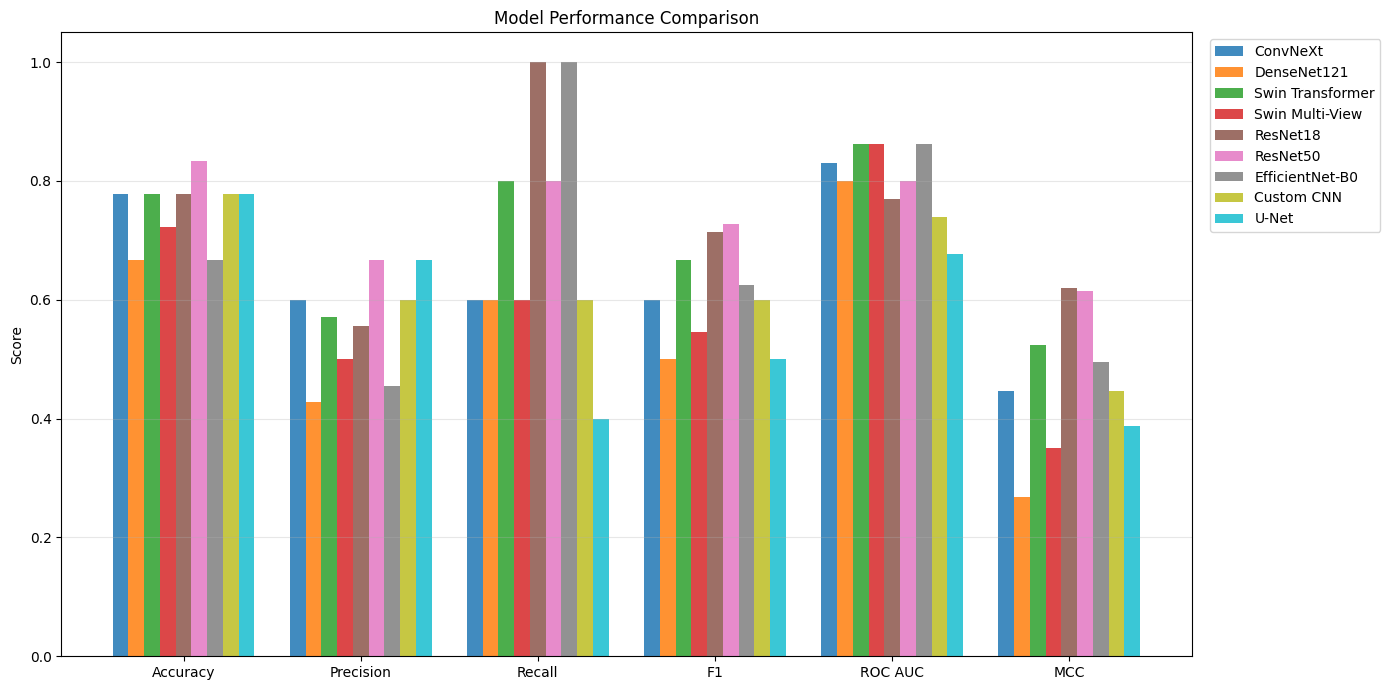


--- ROC Curves ---


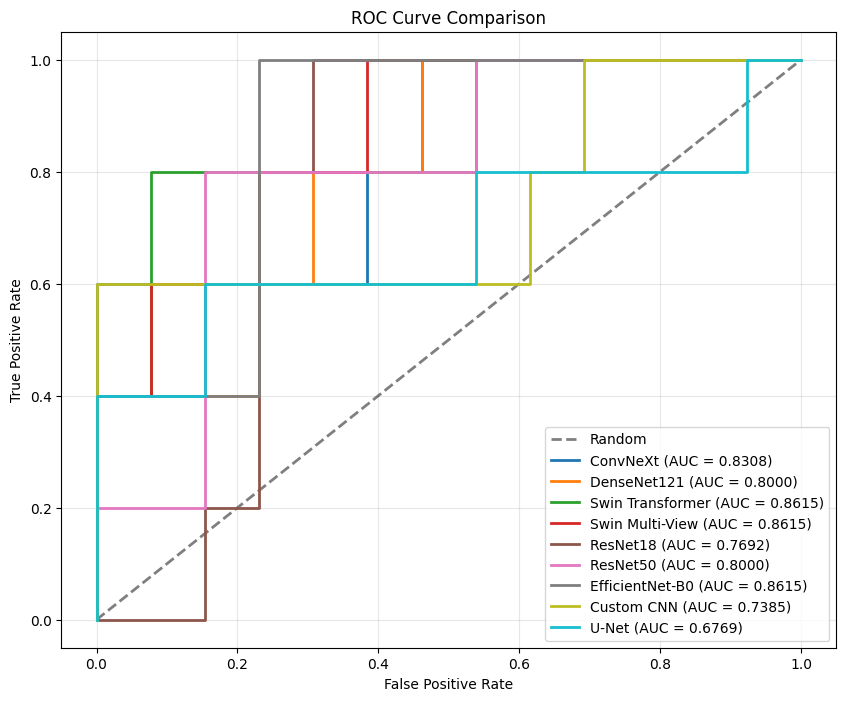


--- Report Generation ---
Summary report saved to: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\comparison_summary.txt

Best Model (F1): ResNet50

Analysis Complete. Check folder: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison


In [ ]:
COMPARISON_DIR = os.path.join(BASE_RESULTS_DIR, "comparison")
os.makedirs(COMPARISON_DIR, exist_ok=True)

MODELS_MAP = {
    'ConvNeXt': 'convnext',
    'DenseNet121': 'densenet121',
    'Swin Transformer': 'swin',
    'Swin Multi-View': 'swin_multiview',
    'ResNet18': 'resnet18',
    'ResNet50': 'resnet50',
    'EfficientNet-B0': 'efficientnet',
    'Custom CNN': 'custom_cnn',
    'U-Net': 'unet'
}

print("\nRunning Advanced Analysis...")
comparator = ModelComparator(BASE_RESULTS_DIR)

# 1. Load Data
metrics = comparator.load_metrics()

if metrics:
    # 2. Table
    print("\n--- Comparison Table ---")
    df_results = comparator.create_comparison_table()
    display(df_results)

    # 3. Bar Chart
    print("\n--- Metrics Visualization ---")
    comparator.plot_bar_chart()

    # 4. ROC Curves
    print("\n--- ROC Curves ---")
    comparator.plot_roc_curves()

    # 5. Summary Report
    print("\n--- Report Generation ---")
    comparator.generate_summary_report()

    print(f"\nAnalysis Complete. Check folder: {COMPARISON_DIR}")
else:
    print("No trained models found to compare. Please run the training pipeline first.")

In [ ]:
def load_metrics(model_name, metrics_path):
    """Load metrics from CSV file"""
    try:
        df = pd.read_csv(metrics_path)
        metrics = df.iloc[0].to_dict()
        print(f"Loaded metrics for {model_name}")
        return metrics
    except Exception as e:
        print(f"Error loading {model_name} metrics: {e}")
        return None


def create_all_models_comparison_table(all_metrics):
    """Create comparison table for all models"""

    if not all_metrics:
        return None

    # Get all metric names from first model
    first_model = list(all_metrics.keys())[0]
    metric_names = list(all_metrics[first_model].keys())

    # Create comparison data
    comparison_data = {'Metric': [metric.replace('_', ' ') for metric in metric_names]}

    # Add each model's metrics
    for model_name, metrics in all_metrics.items():
        comparison_data[model_name] = [f"{metrics[metric]:.4f}" for metric in metric_names]

    df = pd.DataFrame(comparison_data)

    # Save to CSV
    csv_path = os.path.join(COMPARISON_DIR, "all_models_comparison.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved all models comparison: {csv_path}")

    return df


def create_metrics_comparison_table(convnext_metrics, densenet_metrics):
    """Create and save comparison table (legacy function for backward compatibility)"""

    comparison_data = {
        'Metric': [],
        'ConvNeXt': [],
        'DenseNet121': [],
        'Difference': []
    }

    for metric in convnext_metrics.keys():
        comparison_data['Metric'].append(metric.replace('_', ' '))
        convnext_val = convnext_metrics[metric]
        densenet_val = densenet_metrics[metric]
        comparison_data['ConvNeXt'].append(f"{convnext_val:.4f}")
        comparison_data['DenseNet121'].append(f"{densenet_val:.4f}")
        diff = densenet_val - convnext_val
        comparison_data['Difference'].append(f"{diff:+.4f}")

    df = pd.DataFrame(comparison_data)
    # Legacy: keep the table in memory only, do not write metrics_comparison.csv anymore
    return df


def print_all_models_comparison_table(df):
    """Print formatted comparison table for all models"""
    print("\nAll Models Performance Comparison")
    print("=" * 120)

    # Create header
    header = f"{'Metric':<20}"
    for col in df.columns[1:]:  # Skip 'Metric' column
        header += f"{col:<12}"
    print(header)
    print("-" * 120)

    # Print each row
    for _, row in df.iterrows():
        row_str = f"{row['Metric']:<20}"
        for col in df.columns[1:]:
            row_str += f"{row[col]:<12}"
        print(row_str)

    print("=" * 120)


def print_comparison_table(df):
    """Print formatted comparison table (legacy for 2 models)"""
    print("\nModel Performance Comparison")
    print("-" * 70)
    print(f"{'Metric':<25} {'ConvNeXt':<12} {'DenseNet121':<12} {'Difference':<12}")
    print("-" * 70)

    for _, row in df.iterrows():
        print(f"{row['Metric']:<25} {row['ConvNeXt']:<12} {row['DenseNet121']:<12} {row['Difference']:<12}")

    print("-" * 70)


def create_all_models_bar_chart(all_metrics, output_path):
    """Create grouped bar chart comparing all models"""

    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC', 'MCC']
    labels = [m.replace('_', ' ') for m in metrics_to_plot]

    model_names = list(all_metrics.keys())
    colors = ['#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#17BECF', '#BCBD22']

    x = np.arange(len(labels))
    width = 0.10

    fig, ax = plt.subplots(figsize=(16, 8))

    for i, (model_name, metrics) in enumerate(all_metrics.items()):
        values = [metrics[m] for m in metrics_to_plot]
        offset = (i - len(model_names)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=model_name,
                     color=colors[i % len(colors)], alpha=0.8)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.05:  # Only show labels for visible bars
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.2f}',
                       ha='center', va='bottom', fontsize=7, rotation=0)

    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('All Models Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.1])

    plt.tight_layout()
    plt.show()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved all models bar chart: {output_path}")


def create_metrics_bar_chart(convnext_metrics, densenet_metrics, output_path):
    """Create grouped bar chart comparing metrics (legacy function)"""

    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC', 'Sensitivity_TPR', 'Specificity_TNR', 'MCC']

    convnext_values = [convnext_metrics[m] for m in metrics_to_plot]
    densenet_values = [densenet_metrics[m] for m in metrics_to_plot]

    labels = [m.replace('_', ' ') for m in metrics_to_plot]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))

    bars1 = ax.bar(x - width/2, convnext_values, width, label='ConvNeXt', color='#FF7F0E', alpha=0.8)
    bars2 = ax.bar(x + width/2, densenet_values, width, label='DenseNet121', color='#2CA02C', alpha=0.8)

    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.0])

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved bar chart: {output_path}")


def load_predictions(model_dir):
    """Load saved predictions from model evaluation"""
    pred_file = os.path.join(model_dir, 'predictions.npz')
    if os.path.exists(pred_file):
        data = np.load(pred_file)
        return data['y_true'], data['y_pred_proba']
    return None, None


def create_roc_comparison(output_path):
    """Create overlaid ROC curves for all models"""
    from sklearn.metrics import roc_curve, auc

    fig, ax = plt.subplots(figsize=(10, 8))

    # Random baseline
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier', alpha=0.5)

    # Color palette for models
    colors = ['#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#17BECF', '#BCBD22']
    color_idx = 0

    # Load and plot each model
    for model_name, model_dir in MODELS_MAP.items():
        model_dir_path = os.path.join(BASE_RESULTS_DIR, model_dir)
        y_true, y_proba = load_predictions(model_dir_path)

        if y_true is not None and y_proba is not None:
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, color=colors[color_idx % len(colors)], lw=2.5,
                   label=f'{model_name} (AUC = {roc_auc:.4f})')
            color_idx += 1
        else:
            print(f"Warning: {model_name} predictions not found")

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved ROC comparison: {output_path}")


def create_pr_comparison(output_path):
    """Create overlaid Precision-Recall curves for all models"""
    from sklearn.metrics import precision_recall_curve, average_precision_score

    fig, ax = plt.subplots(figsize=(10, 8))

    # Color palette for models
    colors = ['#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#17BECF', '#BCBD22']
    color_idx = 0

    # Load and plot each model
    for model_name, model_dir in MODELS_MAP.items():
        model_dir_path = os.path.join(BASE_RESULTS_DIR, model_dir)
        y_true, y_proba = load_predictions(model_dir_path)

        if y_true is not None and y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            pr_auc = average_precision_score(y_true, y_proba)
            ax.plot(recall, precision, color=colors[color_idx % len(colors)], lw=2.5,
                   label=f'{model_name} (AP = {pr_auc:.4f})')
            color_idx += 1
        else:
            print(f"Warning: {model_name} predictions not found")

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Precision-Recall Curve Comparison - All Models', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved PR comparison: {output_path}")


def create_summary_report(all_metrics):
    """Create text summary report for all models"""

    report_path = os.path.join(COMPARISON_DIR, "comparison_summary.txt")

    # Get all metric names from first model
    first_model = list(all_metrics.keys())[0]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC', 'MCC']

    with open(report_path, 'w') as f:
        f.write("CBIS-DDSM Model Comparison Report\n")
        f.write("=" * 100 + "\n\n")

        f.write("Models Compared:\n")
        for i, model in enumerate(all_metrics.keys(), 1):
            f.write(f"  {i}. {model}\n")
        f.write("\n")

        f.write("Dataset: CBIS-DDSM Breast Cancer Mammography\n")
        f.write("Task: Binary Classification (Benign vs Malignant)\n\n")

        f.write("Performance Comparison:\n")
        f.write("-" * 100 + "\n")

        # Header
        header = f"{'Metric':<20}"
        for model in all_metrics.keys():
            header += f"{model:<20}"
        f.write(header + "\n")
        f.write("-" * 100 + "\n")

        # Rows
        for metric in metric_names:
            row_str = f"{metric:<20}"
            for model in all_metrics.keys():
                val = all_metrics[model].get(metric, 0)
                row_str += f"{val:<20.4f}"
            f.write(row_str + "\n")

        f.write("-" * 100 + "\n\n")

        # Best model analysis
        best_f1_model = max(all_metrics.items(), key=lambda x: x[1]['F1'])[0]
        best_auc_model = max(all_metrics.items(), key=lambda x: x[1]['ROC_AUC'])[0]
        best_recall_model = max(all_metrics.items(), key=lambda x: x[1]['Recall'])[0]

        f.write("Summary & Recommendations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Best Overall (F1 Score): {best_f1_model} ({all_metrics[best_f1_model]['F1']:.4f})\n")
        f.write(f"Best Discriminator (ROC AUC): {best_auc_model} ({all_metrics[best_auc_model]['ROC_AUC']:.4f})\n")
        f.write(f"Best Sensitivity (Recall): {best_recall_model} ({all_metrics[best_recall_model]['Recall']:.4f})\n\n")

        f.write("Detailed Analysis:\n")

        # Sort models by F1
        sorted_models = sorted(all_metrics.items(), key=lambda x: x[1]['F1'], reverse=True)

        f.write(f"1. {sorted_models[0][0]} is the top performing model.\n")
        f.write(f"   - F1 Score: {sorted_models[0][1]['F1']:.4f}\n")
        f.write(f"   - ROC AUC: {sorted_models[0][1]['ROC_AUC']:.4f}\n")
        f.write(f"   - Recall: {sorted_models[0][1]['Recall']:.4f}\n")

        if len(sorted_models) > 1:
            f.write(f"\n2. {sorted_models[1][0]} is the runner-up.\n")
            f.write(f"   - F1 Score: {sorted_models[1][1]['F1']:.4f}\n")

        f.write("\nConclusion:\n")
        if best_f1_model == best_auc_model:
            f.write(f"{best_f1_model} is the clear winner, achieving both the highest F1 score and ROC AUC. ")
        else:
            f.write(f"{best_f1_model} shows the best balance of precision and recall, while {best_auc_model} has the best overall discriminative ability. ")

        f.write("For medical screening, high sensitivity (Recall) is crucial to avoid missing malignant cases. ")
        f.write(f"{best_recall_model} achieves the best sensitivity of {all_metrics[best_recall_model]['Recall']:.4f}.\n")

    print(f"Saved summary report: {report_path}")



Model Comparison Analysis
----------------------------------------

Loading model metrics...
Loaded metrics for ConvNeXt
Loaded metrics for DenseNet121
Loaded metrics for Swin Transformer
Loaded metrics for Swin Multi-View
Loaded metrics for ResNet18
Loaded metrics for ResNet50
Loaded metrics for EfficientNet-B0
Loaded metrics for Custom CNN
Loaded metrics for U-Net

Comparing 9 models: ConvNeXt, DenseNet121, Swin Transformer, Swin Multi-View, ResNet18, ResNet50, EfficientNet-B0, Custom CNN, U-Net

Generating all models comparison table...
Saved all models comparison: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\all_models_comparison.csv

All Models Performance Comparison
Metric              ConvNeXt    DenseNet121 Swin TransformerSwin Multi-ViewResNet18    ResNet50    EfficientNet-B0Custom CNN  U-Net       
------------------------------------------------------------------------------------------------------------------------
Accuracy

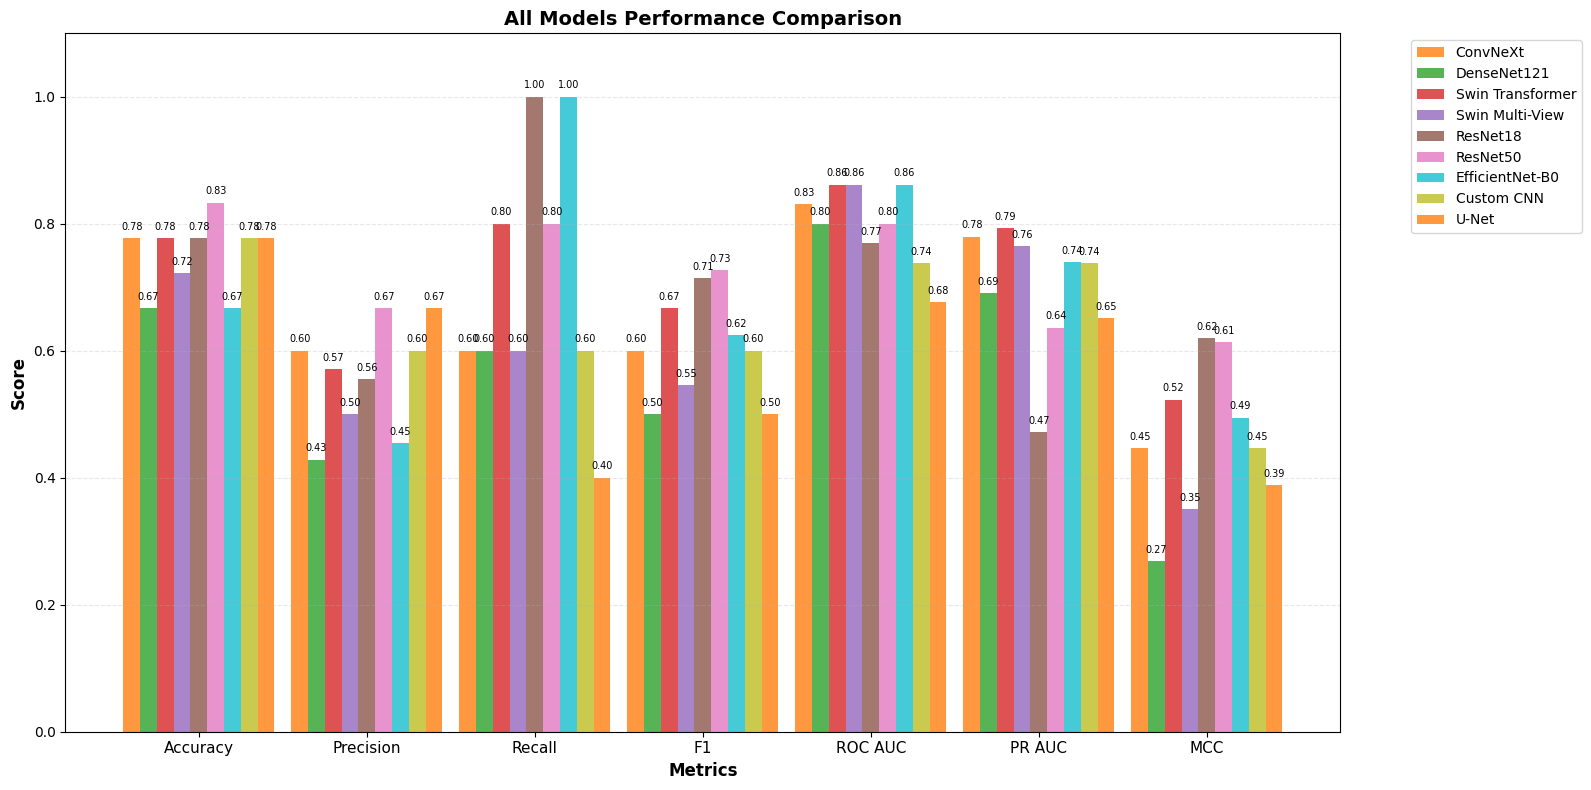

Saved all models bar chart: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\metrics_bar_chart.png


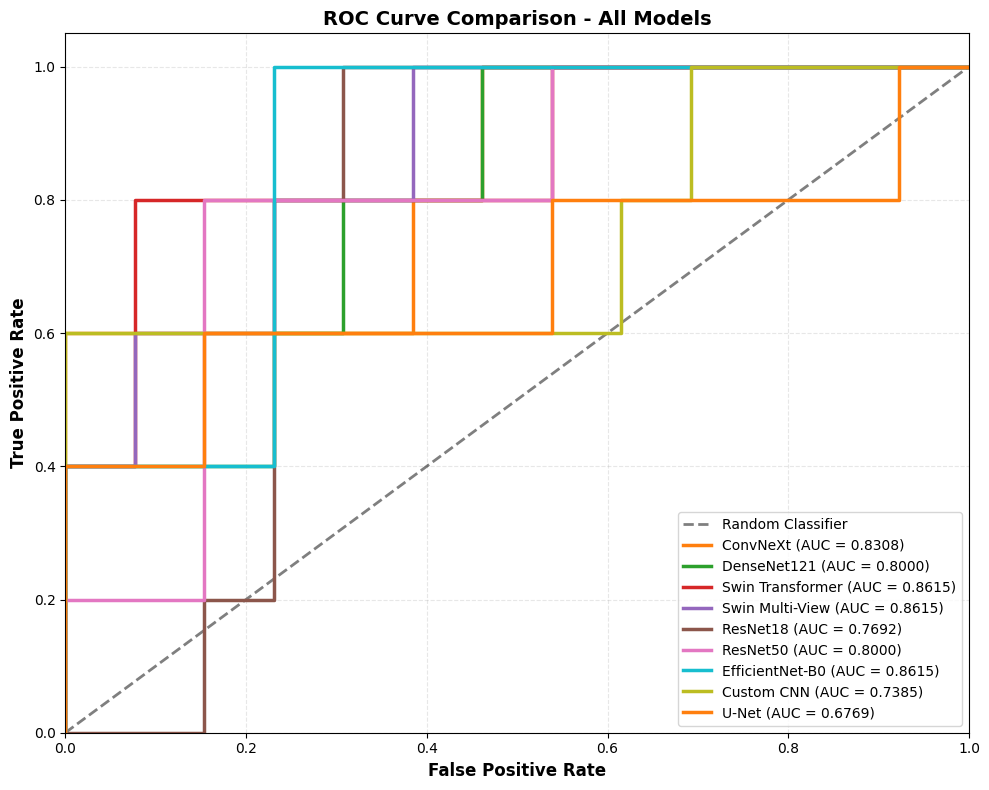

Saved ROC comparison: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\roc_comparison.png


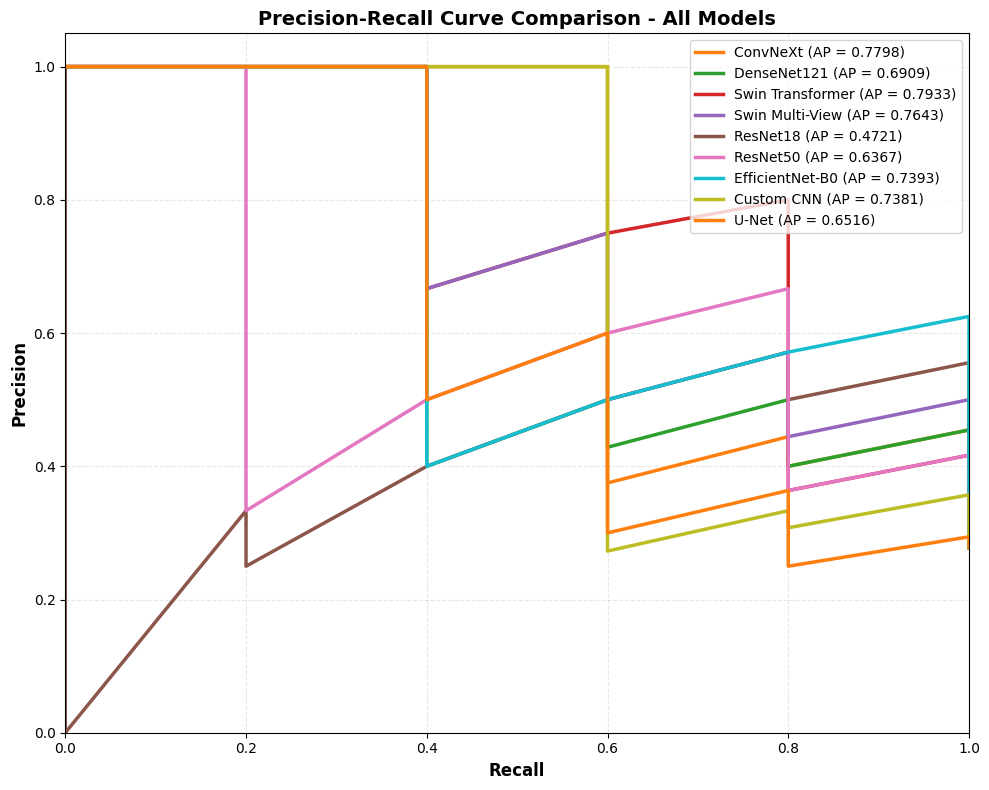

Saved PR comparison: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\pr_comparison.png

Generating summary report...
Saved summary report: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison\comparison_summary.txt

Comparison complete!
Results saved to: C:\Users\uw_admin\Documents\ML\Project\CBIS-DDSM\CBIS_DDSM_Model_Comparison\results\comparison

Generated files:
  - all_models_comparison.csv (metrics table)
  - metrics_bar_chart.png (metrics visualization)
  - roc_comparison.png (ROC curves)
  - pr_comparison.png (PR curves)
  - comparison_summary.txt (text summary)


In [ ]:
print("\nModel Comparison Analysis")
print("-" * 40)

# Load all available model metrics
print("\nLoading model metrics...")
all_metrics = {}

for model_name, model_dir in MODELS_MAP.items():
    metrics_path = os.path.join(BASE_RESULTS_DIR, model_dir, "test_metrics.csv")
    if os.path.exists(metrics_path):
        metrics = load_metrics(model_name, metrics_path)
        if metrics is not None:
            all_metrics[model_name] = metrics
    else:
        print(f"Skipping {model_name} (not yet trained)")

# if len(all_metrics) < 2:
#     print("\nError: Need at least 2 trained models for comparison.")
#     print("Please train more models first.")
#     return

print(f"\nComparing {len(all_metrics)} models: {', '.join(all_metrics.keys())}")

# Create comparison table for ALL models
print("\nGenerating all models comparison table...")
all_models_df = create_all_models_comparison_table(all_metrics)
if all_models_df is not None:
    print_all_models_comparison_table(all_models_df)

# Clean up legacy file if it exists
legacy_csv = os.path.join(COMPARISON_DIR, "metrics_comparison.csv")
if os.path.exists(legacy_csv):
    try:
        os.remove(legacy_csv)
        print("Removed legacy comparison file: metrics_comparison.csv")
    except:
        pass

# Create visualizations
print("\nGenerating comparison visualizations...")

# Bar chart for ALL models
bar_chart_path = os.path.join(COMPARISON_DIR, "metrics_bar_chart.png")
create_all_models_bar_chart(all_metrics, bar_chart_path)

# ROC curve comparison
roc_path = os.path.join(COMPARISON_DIR, "roc_comparison.png")
create_roc_comparison(roc_path)

# PR curve comparison
pr_path = os.path.join(COMPARISON_DIR, "pr_comparison.png")
create_pr_comparison(pr_path)

# Create summary report
print("\nGenerating summary report...")
create_summary_report(all_metrics)

print("\nComparison complete!")
print(f"Results saved to: {COMPARISON_DIR}")
print("\nGenerated files:")
print("  - all_models_comparison.csv (metrics table)")
print("  - metrics_bar_chart.png (metrics visualization)")
print("  - roc_comparison.png (ROC curves)")
print("  - pr_comparison.png (PR curves)")
print("  - comparison_summary.txt (text summary)")
